# sktime for Machine Learning with Time Series

- <a href='https://github.com/alan-turing-institute/sktime'>Link</a> to sktime package 
- <a href='https://www.youtube.com/watch?v=Wf2naBHRo8Q'>Link</a> to presentation
- <a href='https://github.com/sktime/sktime-tutorial-pydata-amsterdam-2020'>Link</a> to github for presentation for notebooks
- <a href='http://learningsys.org/neurips19/assets/papers/sktime_ml_systems_neurips2019.pdf'>Link</a> to paper of the sktime package 
- <a href='https://arxiv.org/abs/2005.08067'>Link</a> to paper (Forecasting with sktime)


### What is sktime?
- a modular, scikit-lean compatible, unified tooldbox for ML with time series
 - other toolboxes a focus  on one specific task 
- includes specialised time series algorithms and tools to build, tune ans evaluate composite models

### Other toolkits for time series 
- <a href='https://www.youtube.com/watch?v=Wf2naBHRo8Q'>Link</a> to related time series toolboxes 



## Time series learning tasks

### What is machine learning with time series?
- <b>Single series</b>
    - Time series annotation (e.g. outlier/anomaly detection, segmentation)
    - Forecasting
- <b>Multivariate time series</b>
    - Timer series annotations with additional variables
    - Forecasting with exogenous variables
    - Vector forecasting (forecasting multiple series at the same time)
- <b>Panel data</b> (longitudinal data - independent measurements of the same kind)
    - Supervised time series
    - Panel/supervised forecasting
    - 'Series-as-features' learning tasks, i.e. time series classification/regression/clustering


### How is it different from standard machine learning?
- intrinsically time series is characterized through observations that are dependent on the previous observations which is against the learning setting of normal machine learning, which states that instances should be independent and identically distributed.
    - for panel data it is plausible that different instances are independent and identically, beside the fact that in a given instance observation is still dependent on the previous observation.
    
### Complications of time series 
- time-heterogeneous data
    - Instances/variables may not share the same common time index
- Storage of data: time series can arise in different settings, and time series data comes in different forms and shapes
    - <a href='https://github.com/alan-turing-institute/sktime/wiki/Time-series-data-container'>Link</a> to time series data container
    
### Reduction
> an algorithm for one task can be adopted to help solve another task -> one-vs-all classification 
- forecasting task can be answered with a regression

## Content
- [rgression]
- Classification univariate
- Classification multivariate



In [48]:
# imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

from sktime.datasets import load_airline
from sktime.forecasting.model_selection import temporal_train_test_split, SlidingWindowSplitter, ForecastingGridSearchCV
from sktime.performance_metrics.forecasting import smape_loss
from sktime.utils.plotting.forecasting import plot_ys
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.compose import EnsembleForecaster, ReducedRegressionForecaster, TransformedTargetForecaster
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.transformers.single_series.detrend import Detrender, Deseasonalizer
from sktime.forecasting.theta import ThetaForecaster

from sklearn.neighbors import KNeighborsRegressor

## Forecasting
> using past data to make temporal forward predictions 
### Data
- monthly passenger data from 1949 - 1960

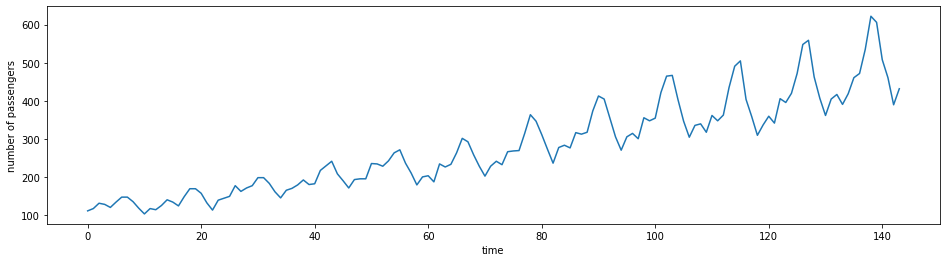

In [8]:
# get data and plot the data
y = load_airline()
fig, ax = plot_ys(y)
ax.set(xlabel='time', ylabel='number of passengers');

### Forecasting task
> predict the last 3 years of data using the previous years as training

#### Steps
1. split the data in train and test
2. define forecasting horizon
3. try different forecasting algorithms
4. evaluate performance with a metric 
    - sMAPE (symmetric mean absolute percentage error)
    
#### 1. split the data in train and test

108 36


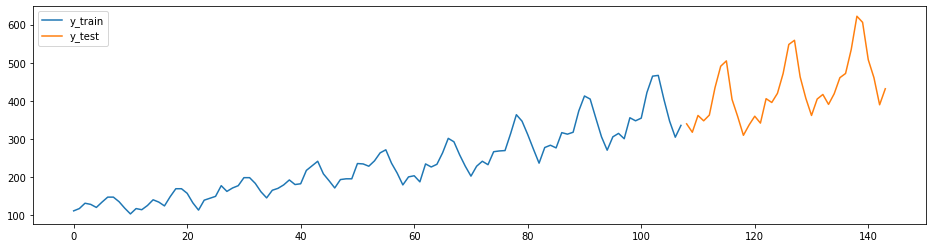

In [11]:
y_train, y_test = temporal_train_test_split(y, test_size=36)
plot_ys(y_train, y_test, labels=['y_train', 'y_test'])
print(y_train.shape[0], y_test.shape[0])

#### 2. define forecasting horizon
- use a numpy array to specify the horizon
- the numpy array will be passed to the algorithm

In [13]:
# we need to add 1 because the stop value isn't included in np.arange
fh = np.arange(1, len(y_test) + 1)
fh

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36])

#### 3. try different forecasting algorithms

0.2319577038795143


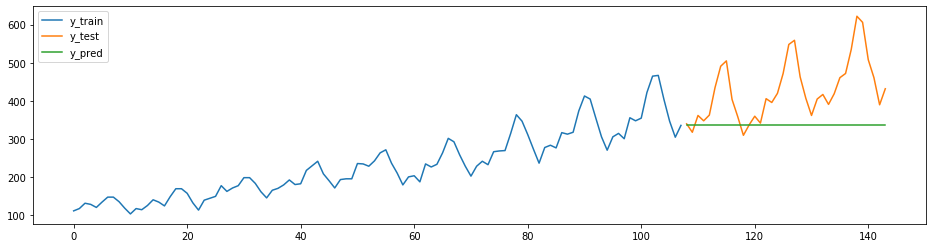

In [19]:
# define forecaster
forecaster = NaiveForecaster(strategy='last')
# fit forecaster
forecaster.fit(y_train)
# use fitted forecaster to make prediction on the forecasting horizon
y_pred = forecaster.predict(fh)
plot_ys(y_train, y_test, y_pred, labels=['y_train', 'y_test', 'y_pred'])
print(smape_loss(y_test, y_pred))

0.145427686270316


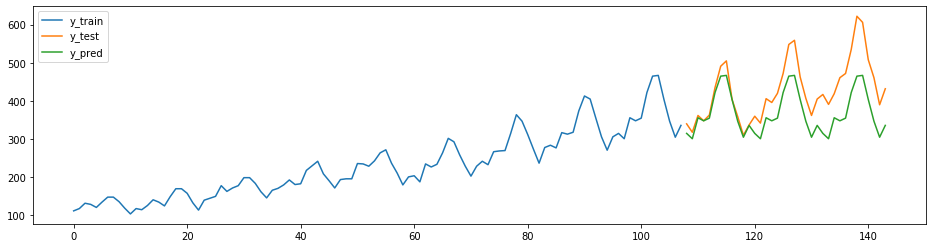

In [20]:
# use different forecasting strategy
forecaster = NaiveForecaster(strategy='seasonal_last', sp=12)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_ys(y_train, y_test, y_pred, labels=['y_train', 'y_test', 'y_pred'])
print(smape_loss(y_test, y_pred))

0.0510740530138247


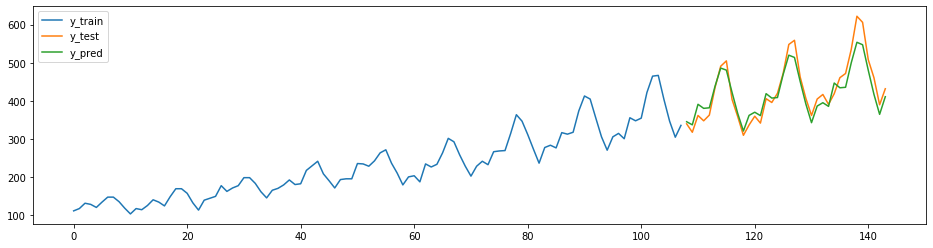

In [22]:
# use different forecasting strategy
forecaster = ExponentialSmoothing(trend='add', seasonal='multiplicative', sp=12)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_ys(y_train, y_test, y_pred, labels=['y_train', 'y_test', 'y_pred'])
print(smape_loss(y_test, y_pred))

/Users/markusmuller/opt/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


0.041170623681666844


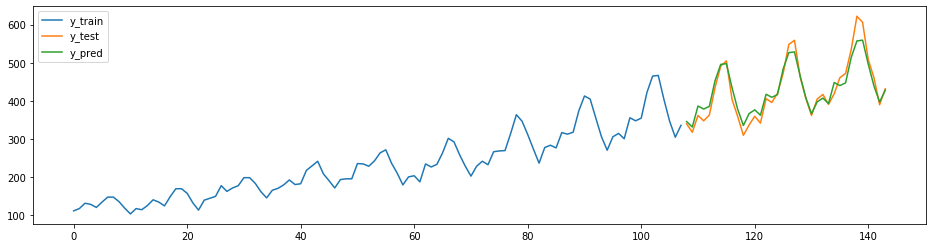

In [26]:
# use different forecasting strategy
forecaster = AutoARIMA(sp=12, suppress_warnings=True)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_ys(y_train, y_test, y_pred, labels=['y_train', 'y_test', 'y_pred'])
print(smape_loss(y_test, y_pred))

#### Compositite models

##### Ensembling
> uses a meta-forecaster to combine multiple models

/Users/markusmuller/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


0.07021684872840556


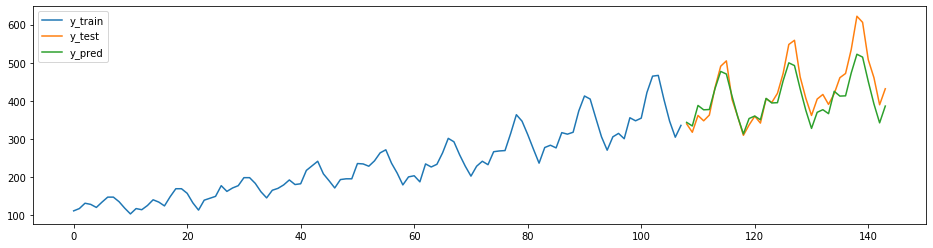

In [29]:
# define ensamble forecaster with different models
forecaster = EnsembleForecaster([
    ('ses', ExponentialSmoothing(seasonal='multiplicative', sp=12)),
    ('holt', ExponentialSmoothing(trend='add', damped=False, seasonal='multiplicative', sp=12)),
    ('damped', ExponentialSmoothing(trend='add', damped=True, seasonal='multiplicative', sp=12))
])
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_ys(y_train, y_test, y_pred, labels=['y_train', 'y_test', 'y_pred'])
print(smape_loss(y_test, y_pred))

##### Tuning
- we can use `ForecastingGridSearchCV` to find the best values for a forecaster
- another possibility is to tune the regressor with using sklearn's `GridSearchCV`

0.14187443909112035


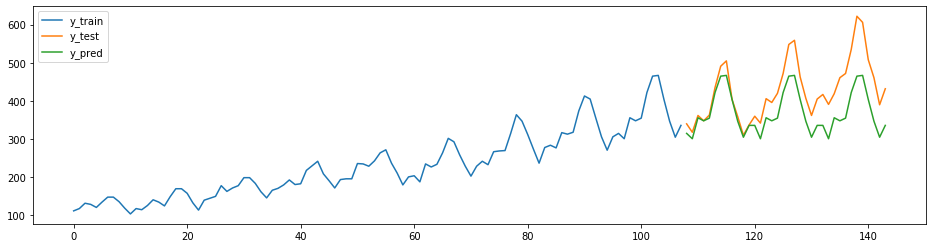

In [36]:
# define sklearn regressor
regressor = KNeighborsRegressor(n_neighbors=1)
forecaster = ReducedRegressionForecaster(regressor=regressor, window_length=15, strategy='recursive')
param_grid = {'window_length': [5, 10, 15]}

# SlidingWindowSplitter is used to splitt the data accordingly 
cv = SlidingWindowSplitter(initial_window=int(len(y_train) * 0.5))
gscv = ForecastingGridSearchCV(forecaster, cv=cv, param_grid=param_grid)
gscv.fit(y_train)
y_pred = gscv.predict(fh)

plot_ys(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);
print(smape_loss(y_test, y_pred))

In [37]:
gscv.best_params_

{'window_length': 15}

##### Detrending
- use sktime's `Detrender` to remove the linear trend from the data

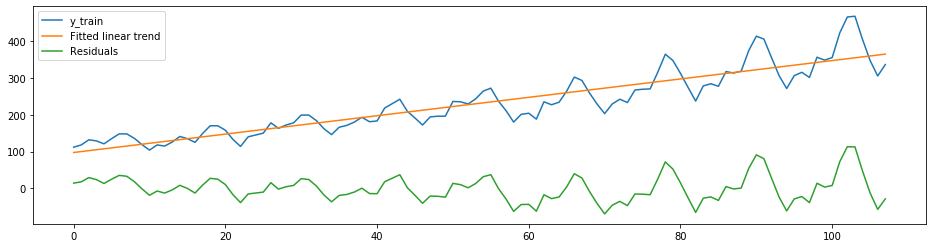

In [40]:
# linear detrending, degree = 1 since it is linear
forecaster = PolynomialTrendForecaster(degree=1)
transformer = Detrender(forecaster=forecaster)
yt = transformer.fit_transform(y_train)

# 
forecaster = PolynomialTrendForecaster(degree=1)
fh_ins = -np.arange(len(y_train))
y_pred = forecaster.fit(y_train).predict(fh=fh_ins)

plot_ys(y_train, y_pred, yt, labels=["y_train", "Fitted linear trend", "Residuals"]);

##### Pipelining
using `detrender` in a pipeline (`TransformTargetForecaster`) with `Deseasonlizer` 

0.04038731595566063


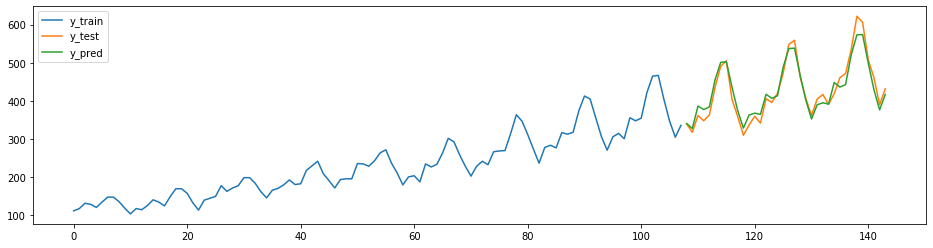

In [43]:
forecaster = TransformedTargetForecaster([
    ('deseasonlise', Deseasonalizer(model='multiplicative', sp=12)),
    ('detrend', Detrender(forecaster=PolynomialTrendForecaster(degree=1))),
    ('forecast', ReducedRegressionForecaster(regressor=regressor, window_length=15, strategy='recursive'))
])

forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_ys(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);
print(smape_loss(y_test, y_pred))

#### Dynamic forecasts
- online learning: dynamically update forecasts as new data comes in

0.09772488427509138


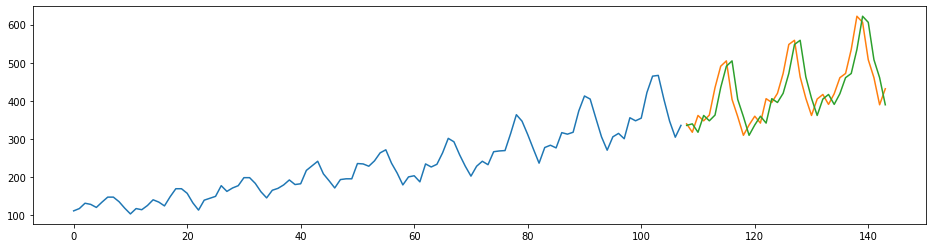

In [47]:
forecaster = NaiveForecaster(strategy="last")
forecaster.fit(y_train)
cv = SlidingWindowSplitter(fh=1)
y_pred = forecaster.update_predict(y_test, cv)
print(smape_loss(y_test, y_pred))
plot_ys(y_train, y_test, y_pred);

#### WIP: prediction intervals
- intervals aren't implemented for every algorithm

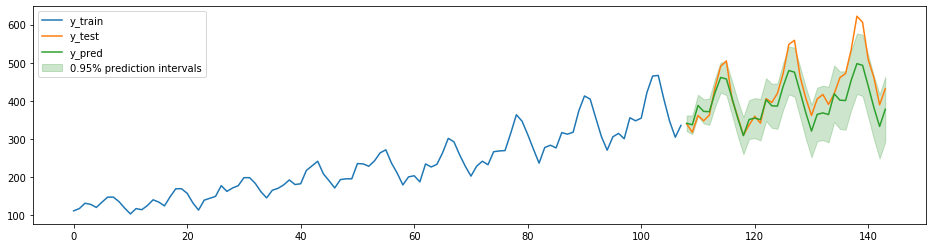

In [49]:
forecaster = ThetaForecaster(sp=12)
forecaster.fit(y_train)
alpha = 0.05
y_pred, pred_ints = forecaster.predict(fh, return_pred_int=True, alpha = alpha)
smape_loss(y_test, y_pred)

fig, ax = plot_ys(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
ax.fill_between(y_pred.index, pred_ints["lower"], pred_ints["upper"], alpha=0.2, color="green", label=f"{1 - alpha}% prediction intervals")
plt.legend();